# 注意力机制

首先回顾一个经典注意力框架，解释如何在视觉场景中展开注意力。 受此框架中的注意力提示（attention cues）的启发， 我们将设计能够利用这些注意力提示的模型。 1964年的Nadaraya-Waston核回归（kernel regression）正是具有 注意力机制（attention mechanism）的机器学习的简单演示。

然后继续介绍的是注意力函数，它们在深度学习的注意力模型设计中被广泛使用。 Bahdanau注意力是深度学习中的具有突破性价值的注意力模型，它双向对齐并且可以微分。

最后将描述仅仅基于注意力机制的Transformer架构， 该架构中使用了多头注意力（multi-head attention） 和自注意力（self-attention）。 自2017年横空出世，Transformer一直都普遍存在于现代的深度学习应用中， 例如语言、视觉、语音和强化学习领域。

## 注意力提示

### 生物学中的注意力提示

- 非自主性提示是基于环境中物体的突出性和易见性。
- 自主性提示则是在我们的认知和意识的控制下，有意识地引导注意力去关注某些具有先验权重的物体。

![由于突出性的非自主性提示（红杯子），注意力不自主地指向了咖啡杯](../image/eye-coffee.svg)   ![依赖于任务的意志提示（想读一本书），注意力被自主引导到书上](../image/eye-book.svg)

### 查询、键和值

![注意力机制通过注意力汇聚将*查询*（自主性提示）和*键*（非自主性提示）结合在一起，实现对*值*（感官输入）的选择倾向](../image/qkv.svg)

在注意力机制的背景下，自主性提示被称为查询（query）。 给定任何查询，注意力机制通过注意力汇聚（attention pooling） 将选择引导至感官输入（sensory inputs，例如中间特征表示）。 在注意力机制中，这些感官输入被称为值（value）。每个值都与一个键（key）配对， 这可以想象为感官输入的非自主提示。可以通过设计注意力汇聚的方式， 便于给定的查询（自主性提示）与键（非自主性提示）进行匹配， 这将引导得出最匹配的值（感官输入）。

### 注意力可视化

In [4]:
import torch
from d2l import torch as d2l

In [5]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

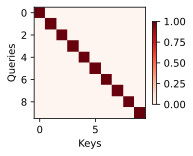

In [6]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 注意力汇聚：Nadaraya-Watson 核回归

### 生成数据集

根据下面的非线性函数生成一个人工数据集，
其中加入的噪声项为$\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

其中$\epsilon$服从均值为$0$和标准差为$0.5$的正态分布。

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 这里生成了50个训练样本和50个测试样本。
# 为了更好地可视化之后的注意力模式，需要将训练样本进行排序。

In [12]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8
# torch.normal(0.0, 0.5, (n_train,)):生成一个长度为 n_train 的一维张量，其中每个元素都是从均值为 0.0、标准差为 0.5 的正态分布中随机抽取的
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [10]:
# 绘制所有的训练样本
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

### 平均汇聚

基于平均汇聚来计算所有训练样本输出值的平均值：

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

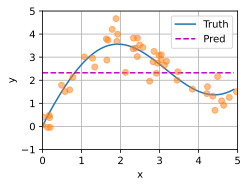

In [13]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### 非参数注意力汇聚

上面平均池化忽略了输入的影响，60年代提出的更好的方案：
$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$

其中$K$是*核*（kernel）。公式描述的估计器被称为
*Nadaraya-Watson核回归*（Nadaraya-Watson kernel regression）。

一个更加通用的*注意力汇聚*（attention pooling）公式：

$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$

其中$x$是查询，$(x_i, y_i)$是键值对。意力汇聚是$y_i$的加权平均。
将查询$x$和键$x_i$之间的关系建模为
*注意力权重*（attention weight）$\alpha(x, x_i)$，这个权重将被分配给每一个对应值$y_i$。
对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：
它们是非负的，并且总和为1。

*高斯核*（Gaussian kernel），其定义为：

$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$

将高斯核带入可以得到：

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$

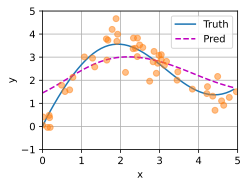

In [17]:
# 基于非参数的注意力汇聚模型来绘制预测结果
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

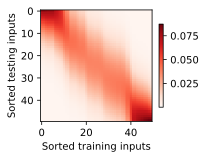

In [18]:
# 观察注意力的权重
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

### 带参数注意力汇聚

在之前的基础上加入可学习参数$w$：

$$\begin{aligned}f(x) &= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$

#### 批量矩阵乘法

 假设第一个小批量数据包含$n$个矩阵$\mathbf{X}_1,\ldots, \mathbf{X}_n$，
形状为$a\times b$，
第二个小批量包含$n$个矩阵$\mathbf{Y}_1, \ldots, \mathbf{Y}_n$，
形状为$b\times c$。
它们的批量矩阵乘法得到$n$个矩阵
$\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$，
形状为$a\times c$。
因此，[**假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$，
它们的批量矩阵乘法输出的形状为$(n,a,c)$**]。

In [22]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
print(torch.bmm(X, Y))
torch.bmm(X, Y).shape


tensor([[[4., 4., 4., 4., 4., 4.]],

        [[4., 4., 4., 4., 4., 4.]]])


torch.Size([2, 1, 6])

In [21]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(weights,values)
# weights.unsqueeze(1) 会在weights张量的第二个维度上增加一个大小为1的维度。weights shape变为torch.Size([2, 1, 10])
# -1 代表最后一个维度 values shape变为torch.Size([2, 1, 10])
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]]) tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]])


tensor([[[ 4.5000]],

        [[14.5000]]])

#### 定义模型

In [28]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

#### 训练

In [29]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

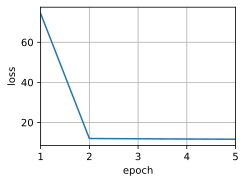

In [30]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

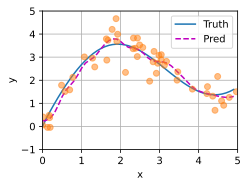

In [31]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

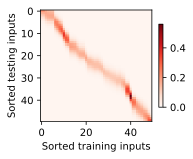

In [32]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 注意力评分函数

注意力评分函数是注意力机制中的核心组件，它用于计算查询（Query）与键（Key）之间的相似度或相关性。
计算过程：
- 首先，根据具体的注意力机制（如加性注意力或点积注意力），选择适当的评分函数。
- 将查询和键作为输入，通过评分函数计算出一个实数值，表示它们之间的相似度或相关性。
- 对所有键的评分进行归一化处理，通常使用softmax函数，以确保所有键的权重之和为1。
- 最后，根据这些权重计算加权和，得到注意力机制的输出。

![计算注意力汇聚的输出为值的加权和](../image/attention-output.svg)

用数学语言描述，假设有一个查询
$\mathbf{q} \in \mathbb{R}^q$和
$m$个“键－值”对
$(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，
其中$\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。
注意力汇聚函数$f$就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$


其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量）
是通过注意力评分函数$a$将两个向量映射成标量，
再经过softmax运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$

In [33]:
import math
import torch
from torch import nn
from d2l import torch as d2l

### 掩蔽softmax操作
为了仅将有意义的词元作为值来获取注意力汇聚， 可以指定一个有效序列长度（即词元的个数）， 以便在计算softmax时过滤掉超出指定范围的位置。 下面的masked_softmax函数 实现了这样的掩蔽softmax操作（masked softmax operation）， 其中任何超出有效长度的位置都被掩蔽并置为0。

In [34]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

考虑由两个 2×4 矩阵表示的样本， 这两个样本的有效长度分别为 2 和 3 。 经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。

In [73]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5489, 0.4511, 0.0000, 0.0000],
         [0.3998, 0.6002, 0.0000, 0.0000]],

        [[0.2091, 0.4485, 0.3424, 0.0000],
         [0.3345, 0.4296, 0.2359, 0.0000]]])

### 加性注意力

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。
给定查询$\mathbf{q} \in \mathbb{R}^q$和
键$\mathbf{k} \in \mathbb{R}^k$，
*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$


其中可学习的参数是$\mathbf W_q\in\mathbb R^{h\times q}$、
$\mathbf W_k\in\mathbb R^{h\times k}$和
$\mathbf w_v\in\mathbb R^{h}$。

In [82]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [83]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

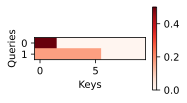

In [84]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### 缩放点积注意力

假设查询和键的所有元素都是独立的随机变量，
并且都满足零均值和单位方差，
那么两个向量的点积的均值为$0$，方差为$d$。
为确保无论向量长度如何，
点积的方差在不考虑向量长度的情况下仍然是$1$，
我们再将点积除以$\sqrt{d}$，
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，
例如基于$n$个查询和$m$个键－值对计算注意力，
其中查询和键的长度为$d$，值的长度为$v$。
查询$\mathbf Q\in\mathbb R^{n\times d}$、
键$\mathbf K\in\mathbb R^{m\times d}$和
值$\mathbf V\in\mathbb R^{m\times v}$的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$

In [85]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [86]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

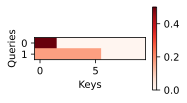

In [87]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Bahdanau 注意力

Bahdanau 注意力机制是一种在序列到序列（seq2seq）模型中应用的注意力机制，它允许模型在处理输出序列时，对输入序列的不同部分赋予不同的注意力权重。这种机制对于处理长序列数据特别有效，因为它可以帮助模型更好地捕捉和理解输入序列中的重要信息。

**基本思想**：Bahdanau 注意力机制的基本思想是在每个解码步骤中，根据输入序列的不同部分与当前解码步骤的相关性，动态地生成上下文向量。这个上下文向量随后被用于辅助生成输出序列。通过这种方式，模型可以在生成输出时，更加关注输入序列中与当前输出最相关的部分。

### 模型

下面描述的Bahdanau注意力模型，假设输入序列中有$T$个词元，
解码时间步$t'$的上下文变量是注意力集中的输出：

$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

其中，时间步$t' - 1$时的解码器隐状态$\mathbf{s}_{t' - 1}$是查询，
编码器隐状态$\mathbf{h}_t$既是键，也是值，
注意力权重$\alpha$是使用加性注意力打分函数计算的。

![一个带有Bahdanau注意力的循环神经网络编码器-解码器模型](../image/seq2seq-attention-details.svg)

In [94]:
import torch
from torch import nn
from d2l import torch as d2l

### 定义注意力解码器

In [95]:
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

让我们在接下来的`Seq2SeqAttentionDecoder`类中
[**实现带有Bahdanau注意力的循环神经网络解码器**]。
首先，初始化解码器的状态，需要下面的输入：

1. 编码器在所有时间步的最终层隐状态，将作为注意力的键和值；
1. 上一时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
1. 编码器有效长度（排除在注意力池中填充词元）。

在每个解码时间步骤中，解码器上一个时间步的最终层隐状态将用作查询。
因此，注意力输出和输入嵌入都连结为循环神经网络解码器的输入。


In [98]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [99]:
# 使用包含7个时间步的4个序列输入的小批量测试Bahdanau注意力解码器
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

### 训练

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

In [ ]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

In [ ]:
# 可视化注意力权重
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

### 小结
- 在预测词元时，如果不是所有输入词元都是相关的，那么具有Bahdanau注意力的循环神经网络编码器-解码器会有选择地统计输入序列的不同部分。这是通过将上下文变量视为加性注意力池化的输出来实现的。

- 在循环神经网络编码器-解码器中，Bahdanau注意力将上一时间步的解码器隐状态视为查询，在所有时间步的编码器隐状态同时视为键和值。